Intensity vs Fermi Chopper frequency -- Chopper 2

Just try the original parameters

In [2]:
cd ~/dv/sns-chops/resolution/ARCS/PyChop/

/SNS/users/lj7/dv/sns-chops/resolution/ARCS/PyChop


In [3]:
import numpy as np, os, sys, glob
from matplotlib import pyplot as plt

In [4]:
from mcni.utils import conversion as C

In [5]:
%matplotlib notebook

# Exp data

In [6]:
import Vdata2018
reload(Vdata2018)

<module 'Vdata2018' from 'Vdata2018.pyc'>

In [7]:
# expdata = Vdata2018.ExpData(os.path.join(Vdata2018.datadir, './V_Cali_Int_Res_FC1_2018.dat'))
expdata = Vdata2018.ExpData(os.path.join(Vdata2018.datadir, './V_Cali_Int_Res_FC2_2018_v2.dat'))

reading data. please wait...
  done


In [8]:
monitor_int_data = np.loadtxt('../V_Cali_MonitorInt_FC2_2018_v2.dat')
runno2monitorint = dict()
for runno, mint, vscatt, duration in monitor_int_data:
    runno2monitorint[int(runno)] = mint/duration

In [9]:
unique_nominal_Eis = set( list(expdata.Ei_list)) 

In [10]:
# unique_nominal_Eis

# Load mcvine sims

In [11]:
mcvine_table = np.loadtxt('../mcvine-FWHM-counts.dat')

In [12]:
mcvine_Eis, mcvine_freqs, mcvine_FWHMs, mcvine_counts = mcvine_table.T

In [13]:
Ei = 100.

In [14]:
condition = np.isclose(expdata.vdata.Energy, Ei)

In [14]:
expdata.vdata.RunNumber[condition]

13     108045.0
28     108064.0
61     108101.0
74     108114.0
96     108138.0
109    108151.0
127    108169.0
142    108184.0
172    108007.0
181    108026.0
Name: RunNumber, dtype: float64

In [15]:
expdata.chopper_freqs[condition]

array([ 180.,  240.,  300.,  360.,  420.,  480.,  540.,  600.,   60.,  120.])

In [16]:
mint = np.array([runno2monitorint[rn] for rn in expdata.vdata.RunNumber[condition]])

In [17]:
mcvine_conditions = np.isclose(mcvine_Eis, Ei)

In [22]:
scale_vscatt2mcvine = 1.1e6
scale_monitor2mcvine = 3

In [ ]:
plt.figure(figsize=(7, 3))

freqs = expdata.chopper_freqs[condition]

plt.subplot(1,2,1)
plt.title('Flux')
plt.plot(mcvine_freqs[mcvine_conditions], mcvine_counts[mcvine_conditions], 'v', label='mcvine')
plt.plot(freqs, mint*C.e2v(Ei)*scale_monitor2mcvine, 'o', label='monitor')
plt.plot(freqs, expdata.intensity[condition]*scale_vscatt2mcvine, '^', label='Vscatt')
plt.plot()
plt.legend()

plt.subplot(1,2,2)
plt.title('Resolution')
plt.plot(freqs, expdata.FWHM[condition], '^', label='exp')
plt.plot(mcvine_freqs[mcvine_conditions], mcvine_FWHMs[mcvine_conditions], 'v', label='mcvine')
plt.legend()

PyChop

In [23]:
sys.path.insert(0, "/SNS/users/lj7/dv")

In [24]:
from PyChop import PyChop2

In [25]:
instrument = PyChop2('arcs-opt.yaml', 'ARCS-100-1.5-SMI', 600)

In [26]:
instrument.getResFlux(Etrans=0, Ei_in=100., frequency=600)

(array([ 4.11798862]), array([ 45.88395835]))

In [21]:
def flux_res_list_pychop(
    fc_freq_list,
    E=0,
    aperture_width=0.1751, S1=281., S2=79., B1=0.087, B2=0.4, Emod=172., 
    Ei = 100.,
    fc_pslit = 1.5, fc_pslat = 0.41, fc_radius=50., fc_rho = 580.,
    fc_choice='ARCS-100-1.5-SMI'):
    
    template = open('./arcs-opt-template.yaml').read()
    content = template.format(aperture_width=aperture_width)
    optyaml = 'arcs-opt.yaml'
    with open(optyaml, 'wt') as of:
        of.write(content)
    instrument = PyChop2(optyaml, fc_choice)
    instrument.ei = Ei
    instrument.moderator.mod_pars = [S1, S2, B1, B2, Emod]
    # print instrument.moderator.mod_pars
    # Fermi chopper
    fc = instrument.chopper_system.packages[fc_choice]
    fc.pslit = fc_pslit
    fc.pslat = fc_pslat
    fc.radius = fc_radius
    fc.rho = fc_rho
    # 
    ret = []
    for freq in fc_freq_list:
        res, flux = instrument.getResFlux(Etrans=E, Ei_in=Ei, frequency=freq)
        res = res[0]; flux = flux[0]
        ret.append( (flux*res, res) )
    return np.array(ret)

In [31]:
flux_scale = 1.6e3

In [ ]:
model_flux, model_res = flux_res_list_pychop(freqs).T

plt.figure(figsize=(7,3))
plt.subplot(1,2,1)
plt.plot(mcvine_freqs[mcvine_conditions], mcvine_counts[mcvine_conditions], 'v', mfc='none', label='mcvine')
plt.plot(freqs, mint*C.e2v(Ei)*scale_monitor2mcvine, '+', label='monitor')
plt.plot(freqs, expdata.intensity[condition]*scale_vscatt2mcvine, '^', label='Vscatt')
plt.plot(freqs, model_flux*flux_scale, 'o', mfc='none', label='pychop')
plt.legend()

plt.subplot(1,2,2)
plt.plot(mcvine_freqs[mcvine_conditions], mcvine_FWHMs[mcvine_conditions], 'v', mfc='none', label='mcvine')
plt.plot(freqs, expdata.FWHM[condition], '+', label='exp')
plt.plot(freqs, model_res, 'o', mfc='none', label='pychop')

plt.legend()

# Try plotting more Eis

1.8angstrom corresponds to ? meV

In [17]:
v_1p8AA = C.k2v(2*np.pi/1.8)

In [18]:
def getExpXY(Ei):
    "return freq, monitor intensity, V scatt intensity, FWHM"
    condition = np.isclose(expdata.vdata.Energy, Ei)
    x = expdata.chopper_freqs[condition]
    y1 = np.array([runno2monitorint[rn] for rn in expdata.vdata.RunNumber[condition]]) *C.e2v(Ei)/v_1p8AA
    y2 = expdata.intensity[condition]  # this is integrated S(E) intensity
    y3 = expdata.FWHM[condition]
    return x,y1,y2,y3

In [19]:
def getMcvineXY(Ei):
    "return freq, counts, FWHM"
    mcvine_conditions = np.isclose(mcvine_Eis, Ei)
    freqs = mcvine_freqs[mcvine_conditions]
    counts = mcvine_counts[mcvine_conditions]
    FWHMs = mcvine_FWHMs[mcvine_conditions]
    return freqs, counts, FWHMs

In [ ]:
Ei = 100
freqs, monInt, vscattInt, expFWHM = getExpXY(Ei)
model_flux, model_res = flux_res_list_pychop(freqs).T
mcv_freqs, mcv_Int, mcv_FWHM = getMcvineXY(Ei)

plt.figure(figsize=(7,3))
plt.subplot(1,2,1)
plt.plot(mcv_freqs, mcv_Int, 'v', mfc='none', label='mcvine')
plt.plot(freqs, monInt, '+', label='monitor')
plt.plot(freqs, vscattInt, '^', mfc='none', label='Vscatt')
plt.plot(freqs, model_flux*flux_scale, 'o', mfc='none', label='pychop')
plt.legend()

plt.subplot(1,2,2)
plt.plot(mcv_freqs, mcv_FWHM, 'v', mfc='none', label='mcvine')
plt.plot(freqs, expFWHM, '+', label='exp')
plt.plot(freqs, model_res, 'o', mfc='none', label='pychop')

plt.legend()

In [37]:
set(expdata.vdata.Energy)

{8.0,
 10.0,
 12.0,
 15.0,
 20.0,
 25.0,
 30.0,
 40.0,
 50.0,
 60.0,
 70.0,
 80.0,
 90.0,
 100.0,
 125.0,
 150.0,
 200.0,
 250.0,
 300.0,
 400.0,
 500.0,
 600.0}

In [42]:
flux_scale = 1.2e3

In [ ]:
Eilist = [10, 100, 400]
N = len(Eilist)
plt.figure(figsize=(8,4))

for i, Ei in enumerate(Eilist):
    freqs, monInt, vscattInt, expFWHM = getExpXY(Ei)
    model_flux, model_res = flux_res_list_pychop(freqs,  Ei=Ei, fc_rho=640.).T
    mcv_freqs, mcv_Int, mcv_FWHM = getMcvineXY(Ei)

    plt.subplot(2, N, i+1)
    plt.title('%smeV - flux' % Ei)
    plt.plot(mcv_freqs, mcv_Int, 'v', mfc='none', label='mcvine')
    plt.plot(freqs, monInt, '+', label='monitor')
    plt.plot(freqs, vscattInt, '^', mfc='none', label='Vscatt')
    plt.plot(freqs, model_flux*flux_scale, 'o', mfc='none', label='pychop')
    plt.legend()

    plt.subplot(2, N, N+i+1)
    plt.title('%smeV - resolution' % Ei)
    plt.plot(mcv_freqs, mcv_FWHM, 'v', mfc='none', label='mcvine')
    plt.plot(freqs, expFWHM, '+', label='exp')
    plt.plot(freqs, model_res, 'o', mfc='none', label='pychop')

    plt.legend()
plt.tight_layout()

# All energies

In [15]:
unique_nominal_Eis

{8.0,
 10.0,
 12.0,
 15.0,
 20.0,
 25.0,
 30.0,
 40.0,
 50.0,
 60.0,
 70.0,
 80.0,
 90.0,
 100.0,
 125.0,
 150.0,
 200.0,
 250.0,
 300.0,
 400.0,
 500.0,
 600.0}

In [66]:
Ei_list = sorted(unique_nominal_Eis)
datatable = dict()
import warnings
for Ei in Ei_list:
    freqs, monInt, vscattInt, expFWHM = getExpXY(Ei)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model_flux, model_res = flux_res_list_pychop(freqs, Ei=Ei, fc_pslat=0.40, fc_pslit=1.52, fc_rho=640.).T
    mcv_freqs, mcv_Int, mcv_FWHM = getMcvineXY(Ei)
    datatable[Ei] = freqs, monInt, vscattInt, expFWHM, model_flux, model_res, mcv_freqs, mcv_Int, mcv_FWHM

 * mcvine scale factor

To make the unit counts per pulse per cm^2, need to divide the mcvine intensity by 25 (5X5 cm^2).
Another factor is the target power. 1.4MW vs 2MW(in mcvine)

In [47]:
mcvine_scale = 1./25 * 1.4/2.

* pychop scale factor

The pychop result is calculated by multiplying mcvine result of flux (counts per pulse per microsecond per meV for 5X5cm^2) by FC transmission factor which is in the unit of $1e-3 * second$
(see https://github.com/mantidproject/mantid/blob/8ee7f81bc297e2627d0c90cd2fe8c2a3aa67f647/scripts/PyChop/Chop.py#L100 and https://github.com/mantidproject/mantid/blob/8ee7f81bc297e2627d0c90cd2fe8c2a3aa67f647/scripts/PyChop/Instruments.py#L97), so the scaling factor is

In [48]:
pychop_scale = 1e-3 * 1e6 /25 * 1.4/2

* monitor data scale factor

According to ARCS paper, monitor efficiency is 1e-5 at $\lambda=1.8$angstrom.
The monitor data was normalized by per second, and then scaled by v/v_at_1.8angstrom. So

In [49]:
mon_scale = 1e5 / 25 /60.
mon_scale *= 2  # fudge factor

* Vanadium scattering

  * a fudge factor
  * detector efficiency is considered

In [53]:
def calc_deteff(He_press = 10., He_T = 300., width = 0.0254*.8, E=100):
    "He_press: atm; He_T: K; width: meter; E: meV"
    pressure = He_press * 101325
    mu = 5333.0e-28/1.798 * np.sqrt(81.81/E) * pressure/He_T * 300*2.414e20
    l = 1./mu
    return 1-np.exp(-width/l)

In [75]:
calc_deteff(He_press = 10., He_T = 300., width = 0.0254*.8, E=100)

0.73642223392033357

In [82]:
vscatt_scale = 2.5e4

<IPython.core.display.Javascript object>


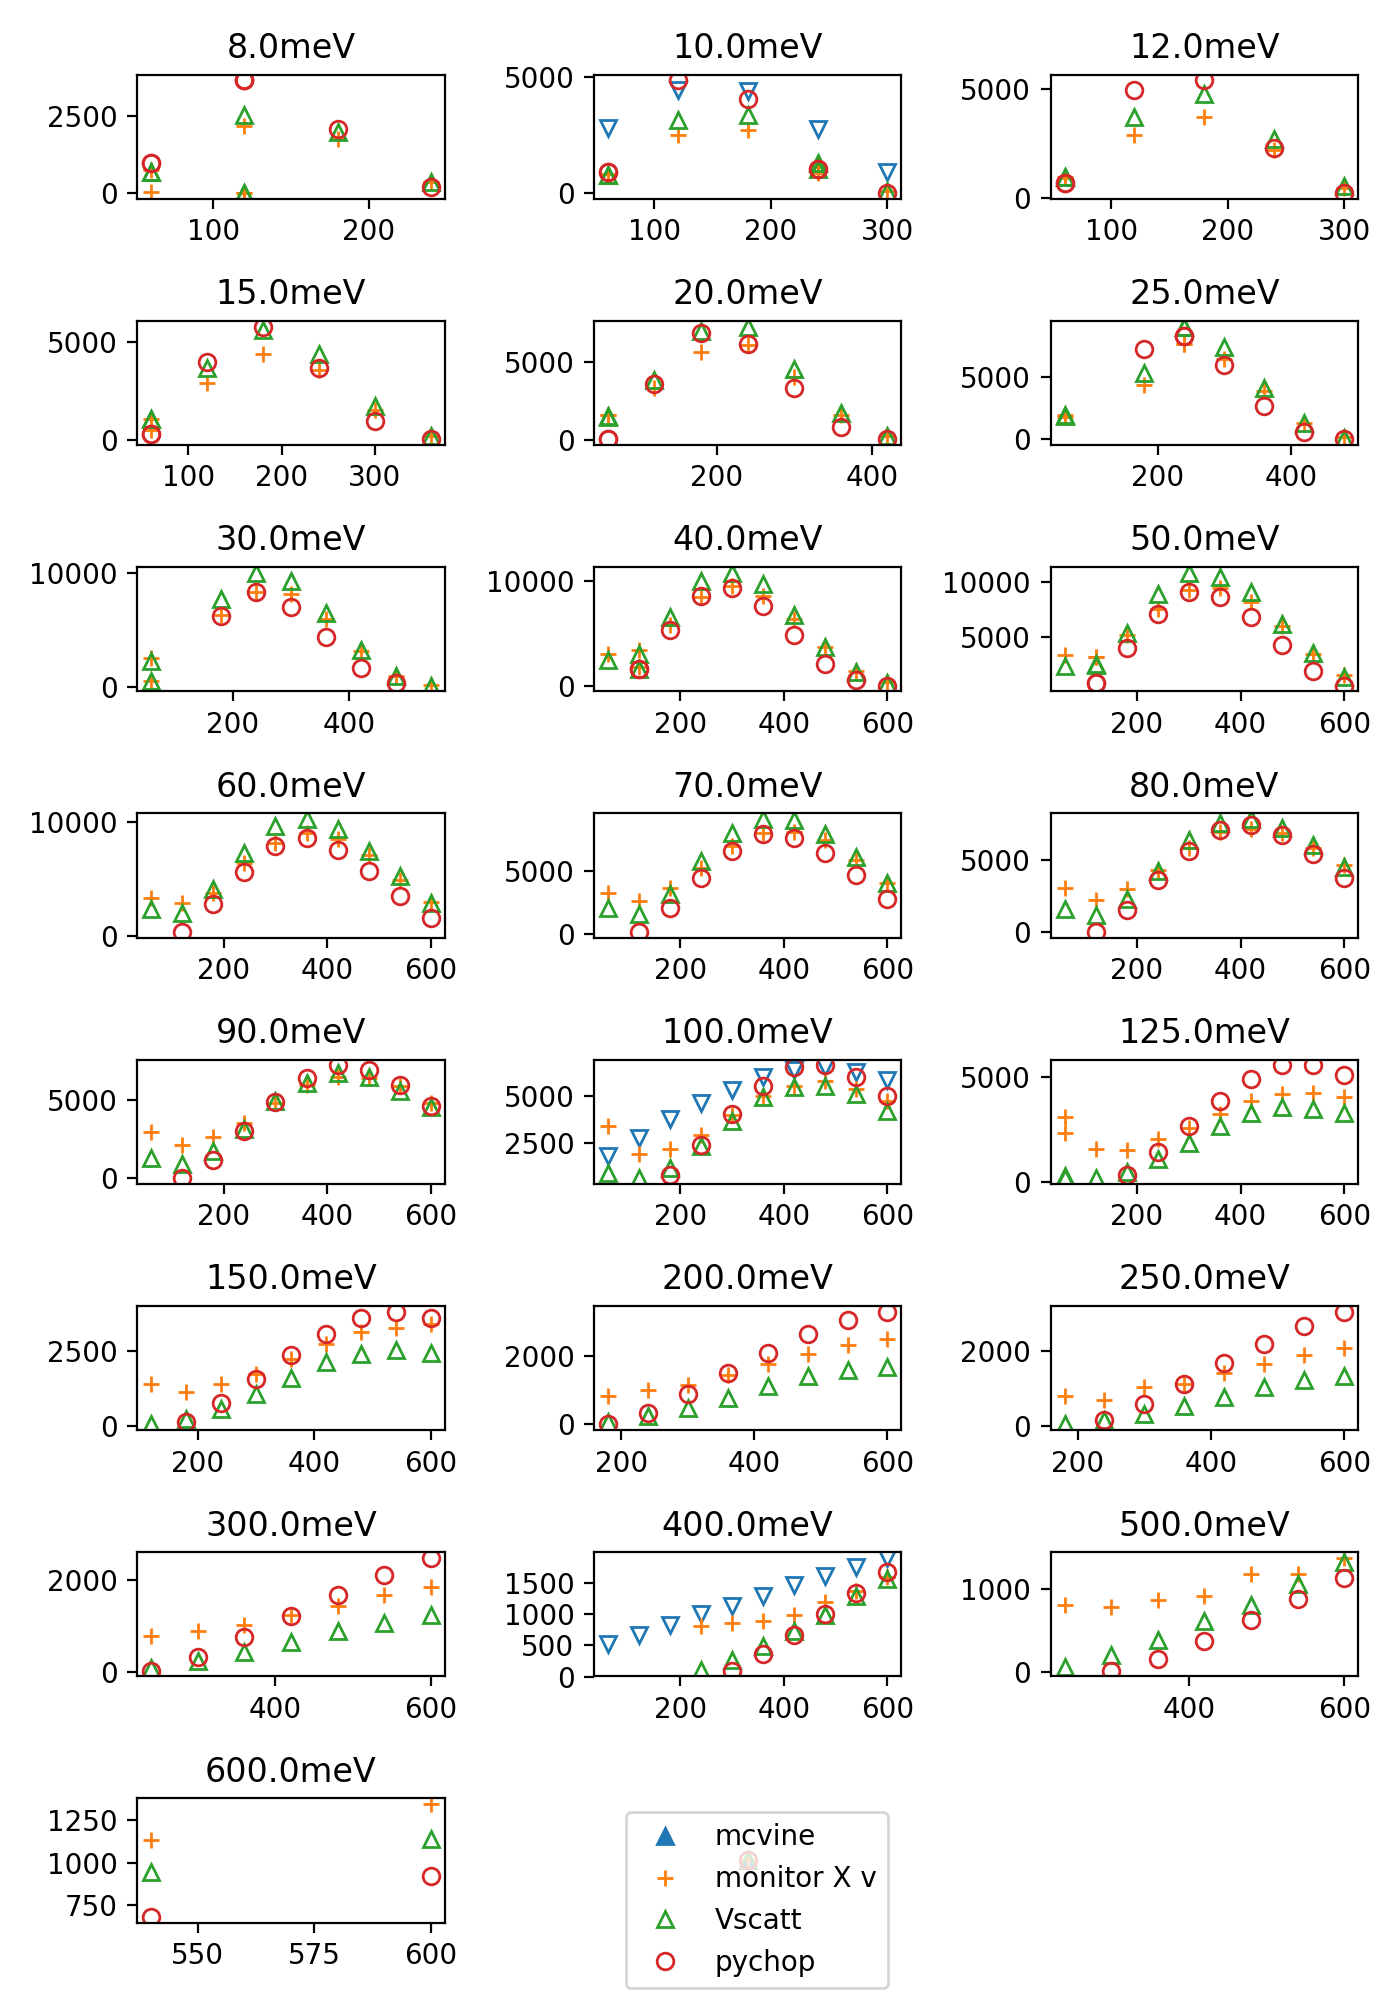

In [83]:
N = len(Ei_list)
cols = 3
# rows = (N-1)//cols + 1
rows = N//cols + 1
plt.figure(figsize=(7,10))

for i, Ei in enumerate(Ei_list):
    freqs, monInt, vscattInt, expFWHM, model_flux, model_res, mcv_freqs, mcv_Int, mcv_FWHM = datatable[Ei]
    # vscattInt /= calc_deteff(He_press = 10., He_T = 300., width = 0.0254*.8, E=Ei)
    plt.subplot(rows, cols, i+1)
    plt.title('%smeV' % Ei)
    plt.plot(mcv_freqs, mcv_Int*mcvine_scale, 'v', mfc='none', label='mcvine')
    plt.plot(freqs, monInt*mon_scale, '+', label='monitor')
    plt.plot(freqs, vscattInt*vscatt_scale, '^', mfc='none', label='Vscatt')
    plt.plot(freqs, model_flux*pychop_scale, 'o', mfc='none', label='pychop')
plt.subplot(rows, cols, N+1)
plt.axis('off')
plt.plot([0], [0], '^', label='mcvine')
plt.plot([0], [0], '+', label='monitor X v')
plt.plot([0], [0], '^', mfc='none', label='Vscatt')
plt.plot([0], [0], 'o', mfc='none', label='pychop')
plt.legend()
plt.tight_layout()

<IPython.core.display.Javascript object>


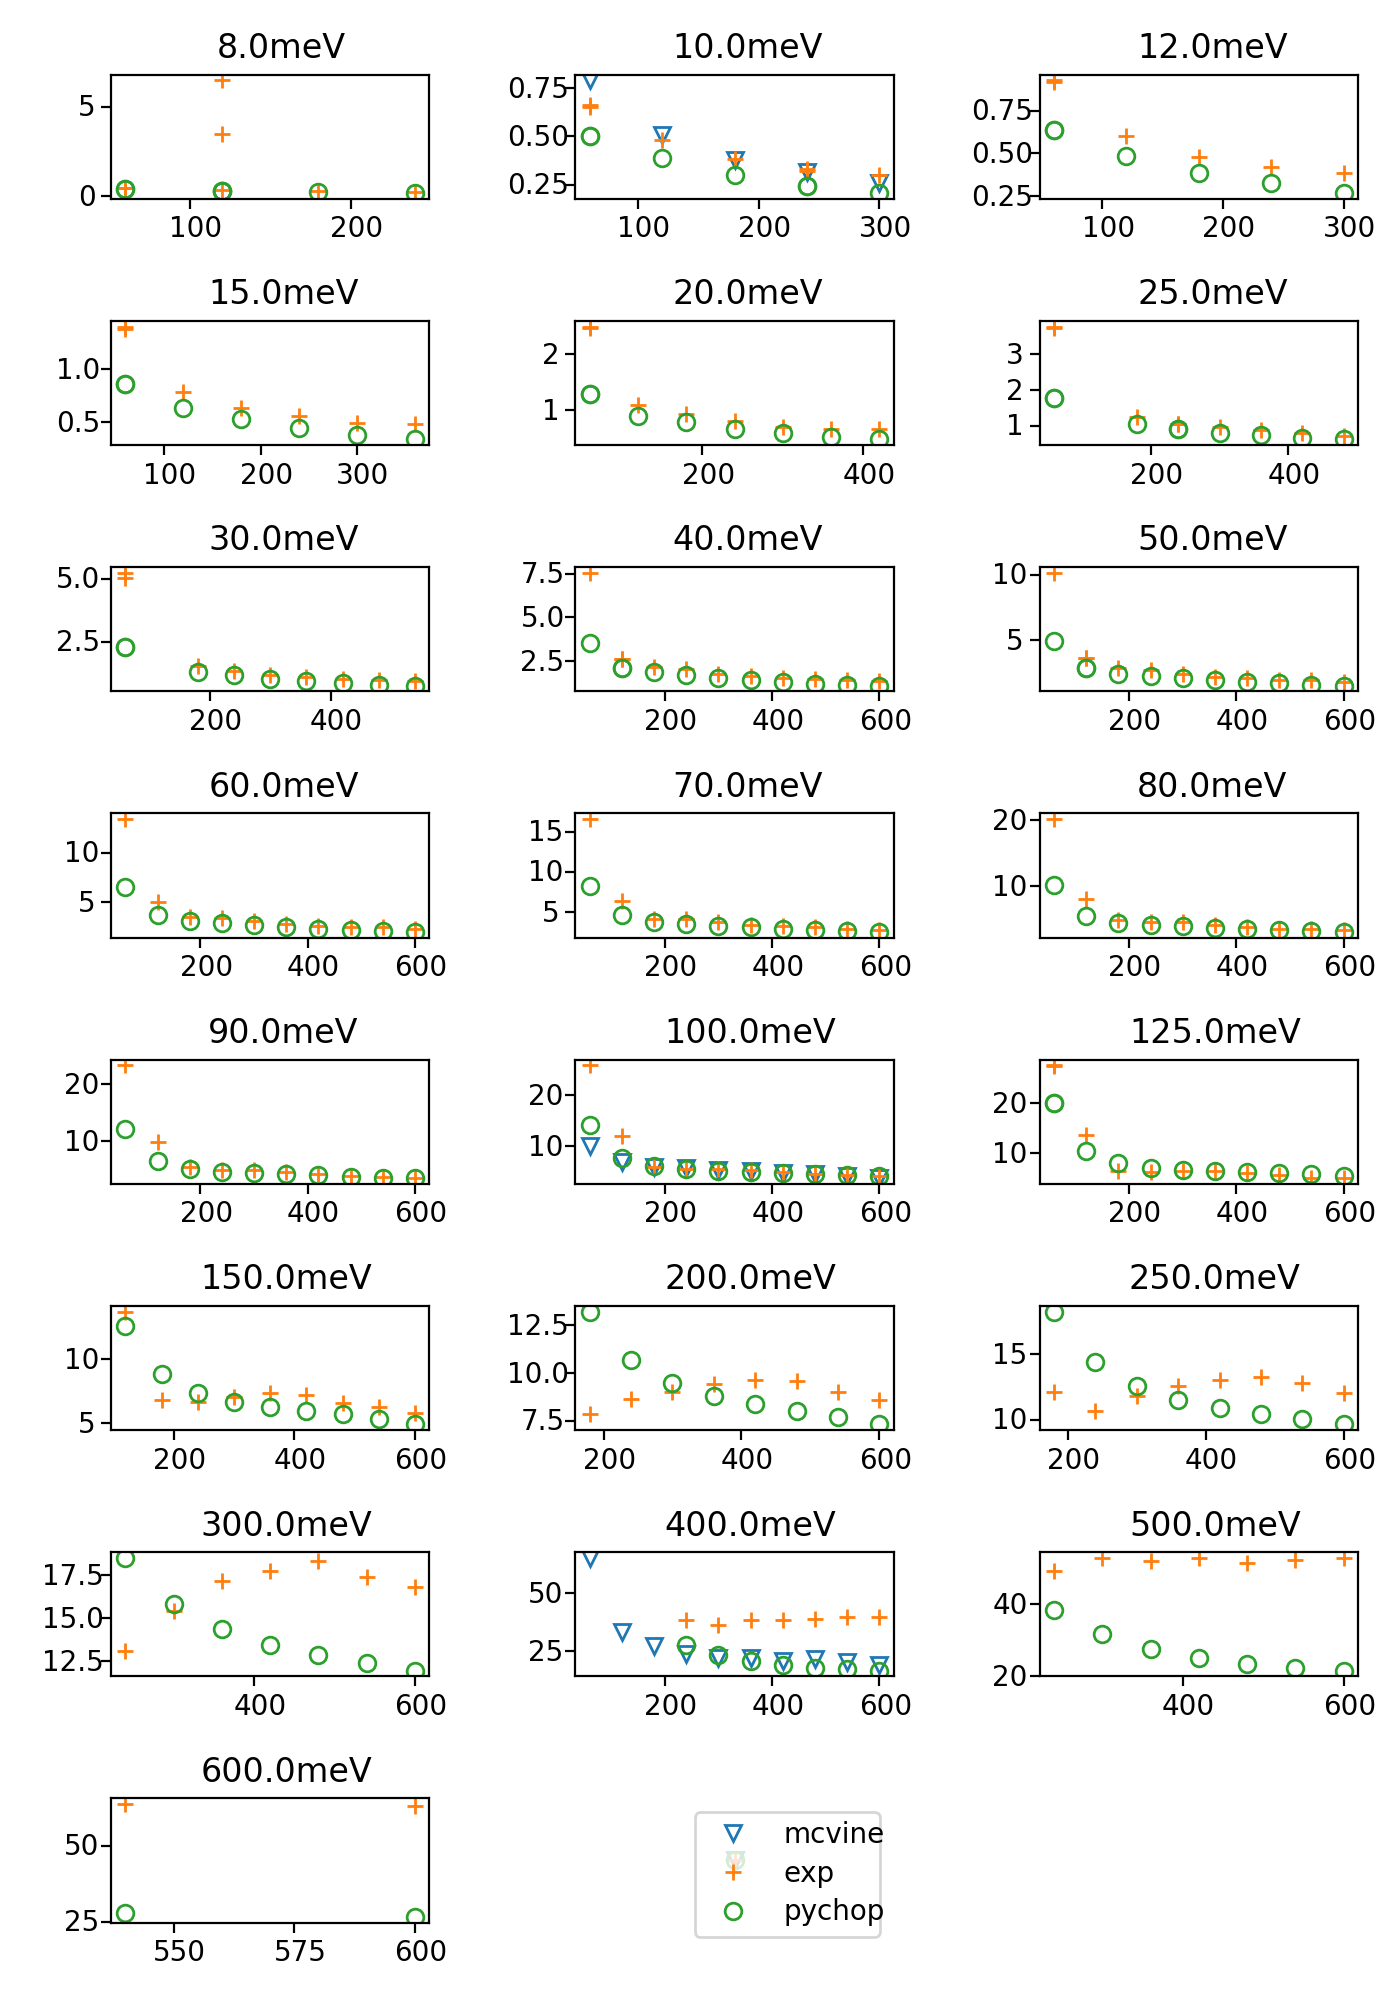

In [84]:
N = len(Ei_list)
cols = 3
# rows = (N-1)//cols + 1
rows = N//cols + 1
plt.figure(figsize=(7,10))

for i, Ei in enumerate(Ei_list):
    freqs, monInt, vscattInt, expFWHM, model_flux, model_res, mcv_freqs, mcv_Int, mcv_FWHM = datatable[Ei]
    plt.subplot(rows, cols, i+1)
    plt.title('%smeV' % Ei)
    plt.plot(mcv_freqs, mcv_FWHM, 'v', mfc='none', label='mcvine')
    plt.plot(freqs, expFWHM, '+', label='exp')
    plt.plot(freqs, model_res, 'o', mfc='none', label='pychop')
plt.subplot(rows, cols, N+1)
plt.axis('off')
plt.plot([0], [0], 'v', mfc='none', label='mcvine')
plt.plot([0], [0], '+', label='exp')
plt.plot([0], [0], 'o', mfc='none', label='pychop')
plt.legend()
plt.tight_layout()

# Some conclusions

* In general agree
* The measured intensities at low FC frequencies for larger Ei are much larger than expected by PyChop. I don't know why there is "leaking" of neutrons at low FC. Maybe a Monte Carlo simulation will help. Those FC freqs are not useful anyway, because FWHMs are large for them
* The resolution function measured at larger Eis are too large. It is due to the phonon data. So for those data we should trust PyChop.